In [2]:
import sys
import os
from glob import glob
from importlib import reload
from collections import OrderedDict as od

import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.io import loadmat
from scipy.io import savemat
import h5py

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 

import mne
sys.path.append('/Users/danielschonhaut/penn/lab/code/general')
import data_io as dio
import eeg_preproc
from eeg_plotting import plot_trace, plot_trace2

In [3]:
def cos_sim(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [4]:
subj_sess = 'U526_ses0'
# -----------------------

subj, sess = subj_sess.split('_')
spikes_dir = os.path.join('/Users/danielschonhaut/penn/lab/projects/time_cells/data', subj, sess, 
                          'spikes', 'wave_clus3_sortbyhand')
os.path.exists(spikes_dir)

True

12710422 detected spikes
12710422/936844 (7.4%) detected spikes are neural
32 neurons across 94 channels


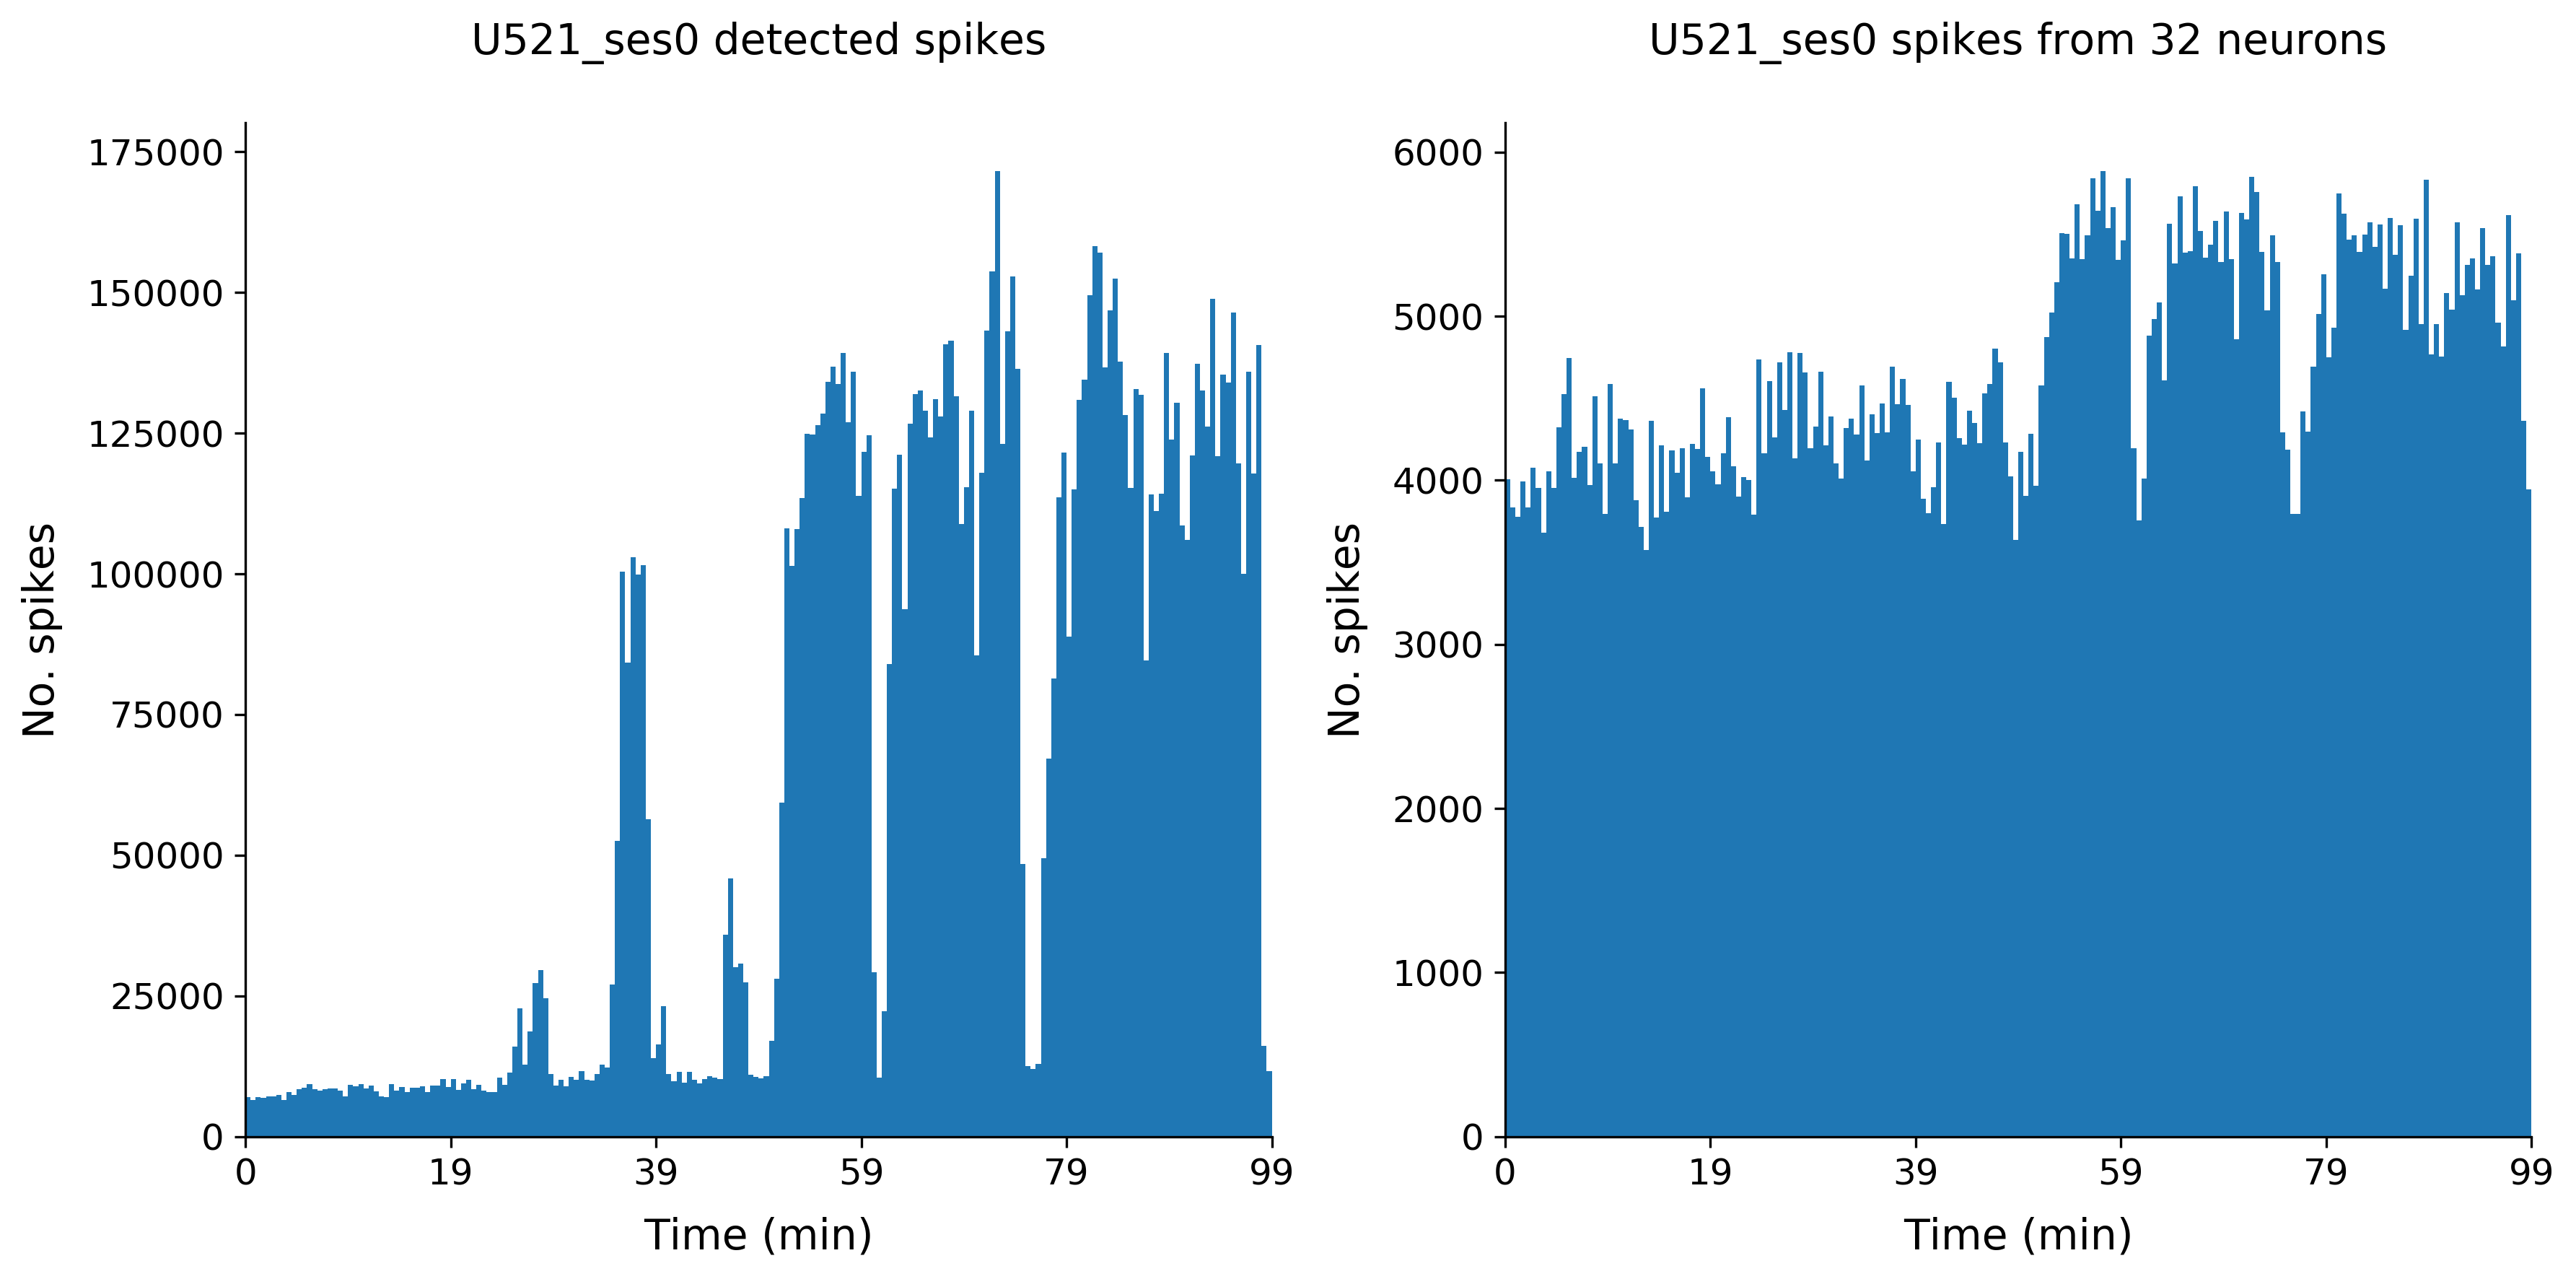

In [53]:
spike_times = []
unit_spike_times = []
n_chans = 94
n_neurons = 0
for chan in [str(i) for i in range(1, n_chans+1)]:
    wave_clusf = os.path.join(spikes_dir, 'times_CSC{}.mat'.format(chan))
    if os.path.exists(wave_clusf):
        dat = loadmat(wave_clusf)['cluster_class']
        spike_times.extend(list(dat[:, 1]))
        neuron_inds = np.where(dat[:, 0]!=0)[0]
        unit_spike_times.extend(list(dat[neuron_inds, 1]))
        n_neurons += len(np.unique(dat[neuron_inds, 0]))
spike_times = np.array(spike_times)
unit_spike_times = np.array(unit_spike_times)
xmin, xmax = np.min(spike_times), np.max(spike_times)

print('{} detected spikes'.format(len(spike_times)))
print('{}/{} ({:.1f}%) detected spikes are neural'.format(len(spike_times), 
                                                          len(unit_spike_times),
                                                          100 * len(unit_spike_times) / len(spike_times)))
print('{} neurons across {} channels'.format(n_neurons, n_chans))

fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
ax = np.ravel(ax)

tickfontsize=12
labelfontsize=14

i = 0
ax[i].hist(spike_times, bins=200, alpha=1)
ax[i].set_xlim(xmin, xmax)
ax[i].set_xticks(np.linspace(xmin, xmax, 6))
ax[i].set_xticklabels(np.linspace(xmin/6e4, xmax/6e4, 6, dtype=int), fontsize=tickfontsize)
ax[i].set_title('{} detected spikes'.format(subj_sess), fontsize=labelfontsize, y=1.05)
ax[i].set_xlabel('Time (min)', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylabel('No. spikes', fontsize=labelfontsize, labelpad=8)

i = 1
ax[i].hist(unit_spike_times, bins=200, alpha=1)
ax[i].set_xlim(xmin, xmax)
ax[i].set_xticks(np.linspace(xmin, xmax, 6))
ax[i].set_xticklabels(np.linspace(xmin/6e4, xmax/6e4, 6, dtype=int), fontsize=tickfontsize)
ax[i].set_title('{} spikes from {} neurons'.format(subj_sess, n_neurons), fontsize=labelfontsize, y=1.05)
ax[i].set_xlabel('Time (min)', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylabel('No. spikes', fontsize=labelfontsize, labelpad=8)

fig.tight_layout()

In [10]:
#chan1_times = dat_[:, 1]
#chan2_times = dat_[:, 1]
chan1_times, chan2_times

Unit 0: 206738 spikes
Unit 1: 1802 spikes
Unit 2: 790 spikes


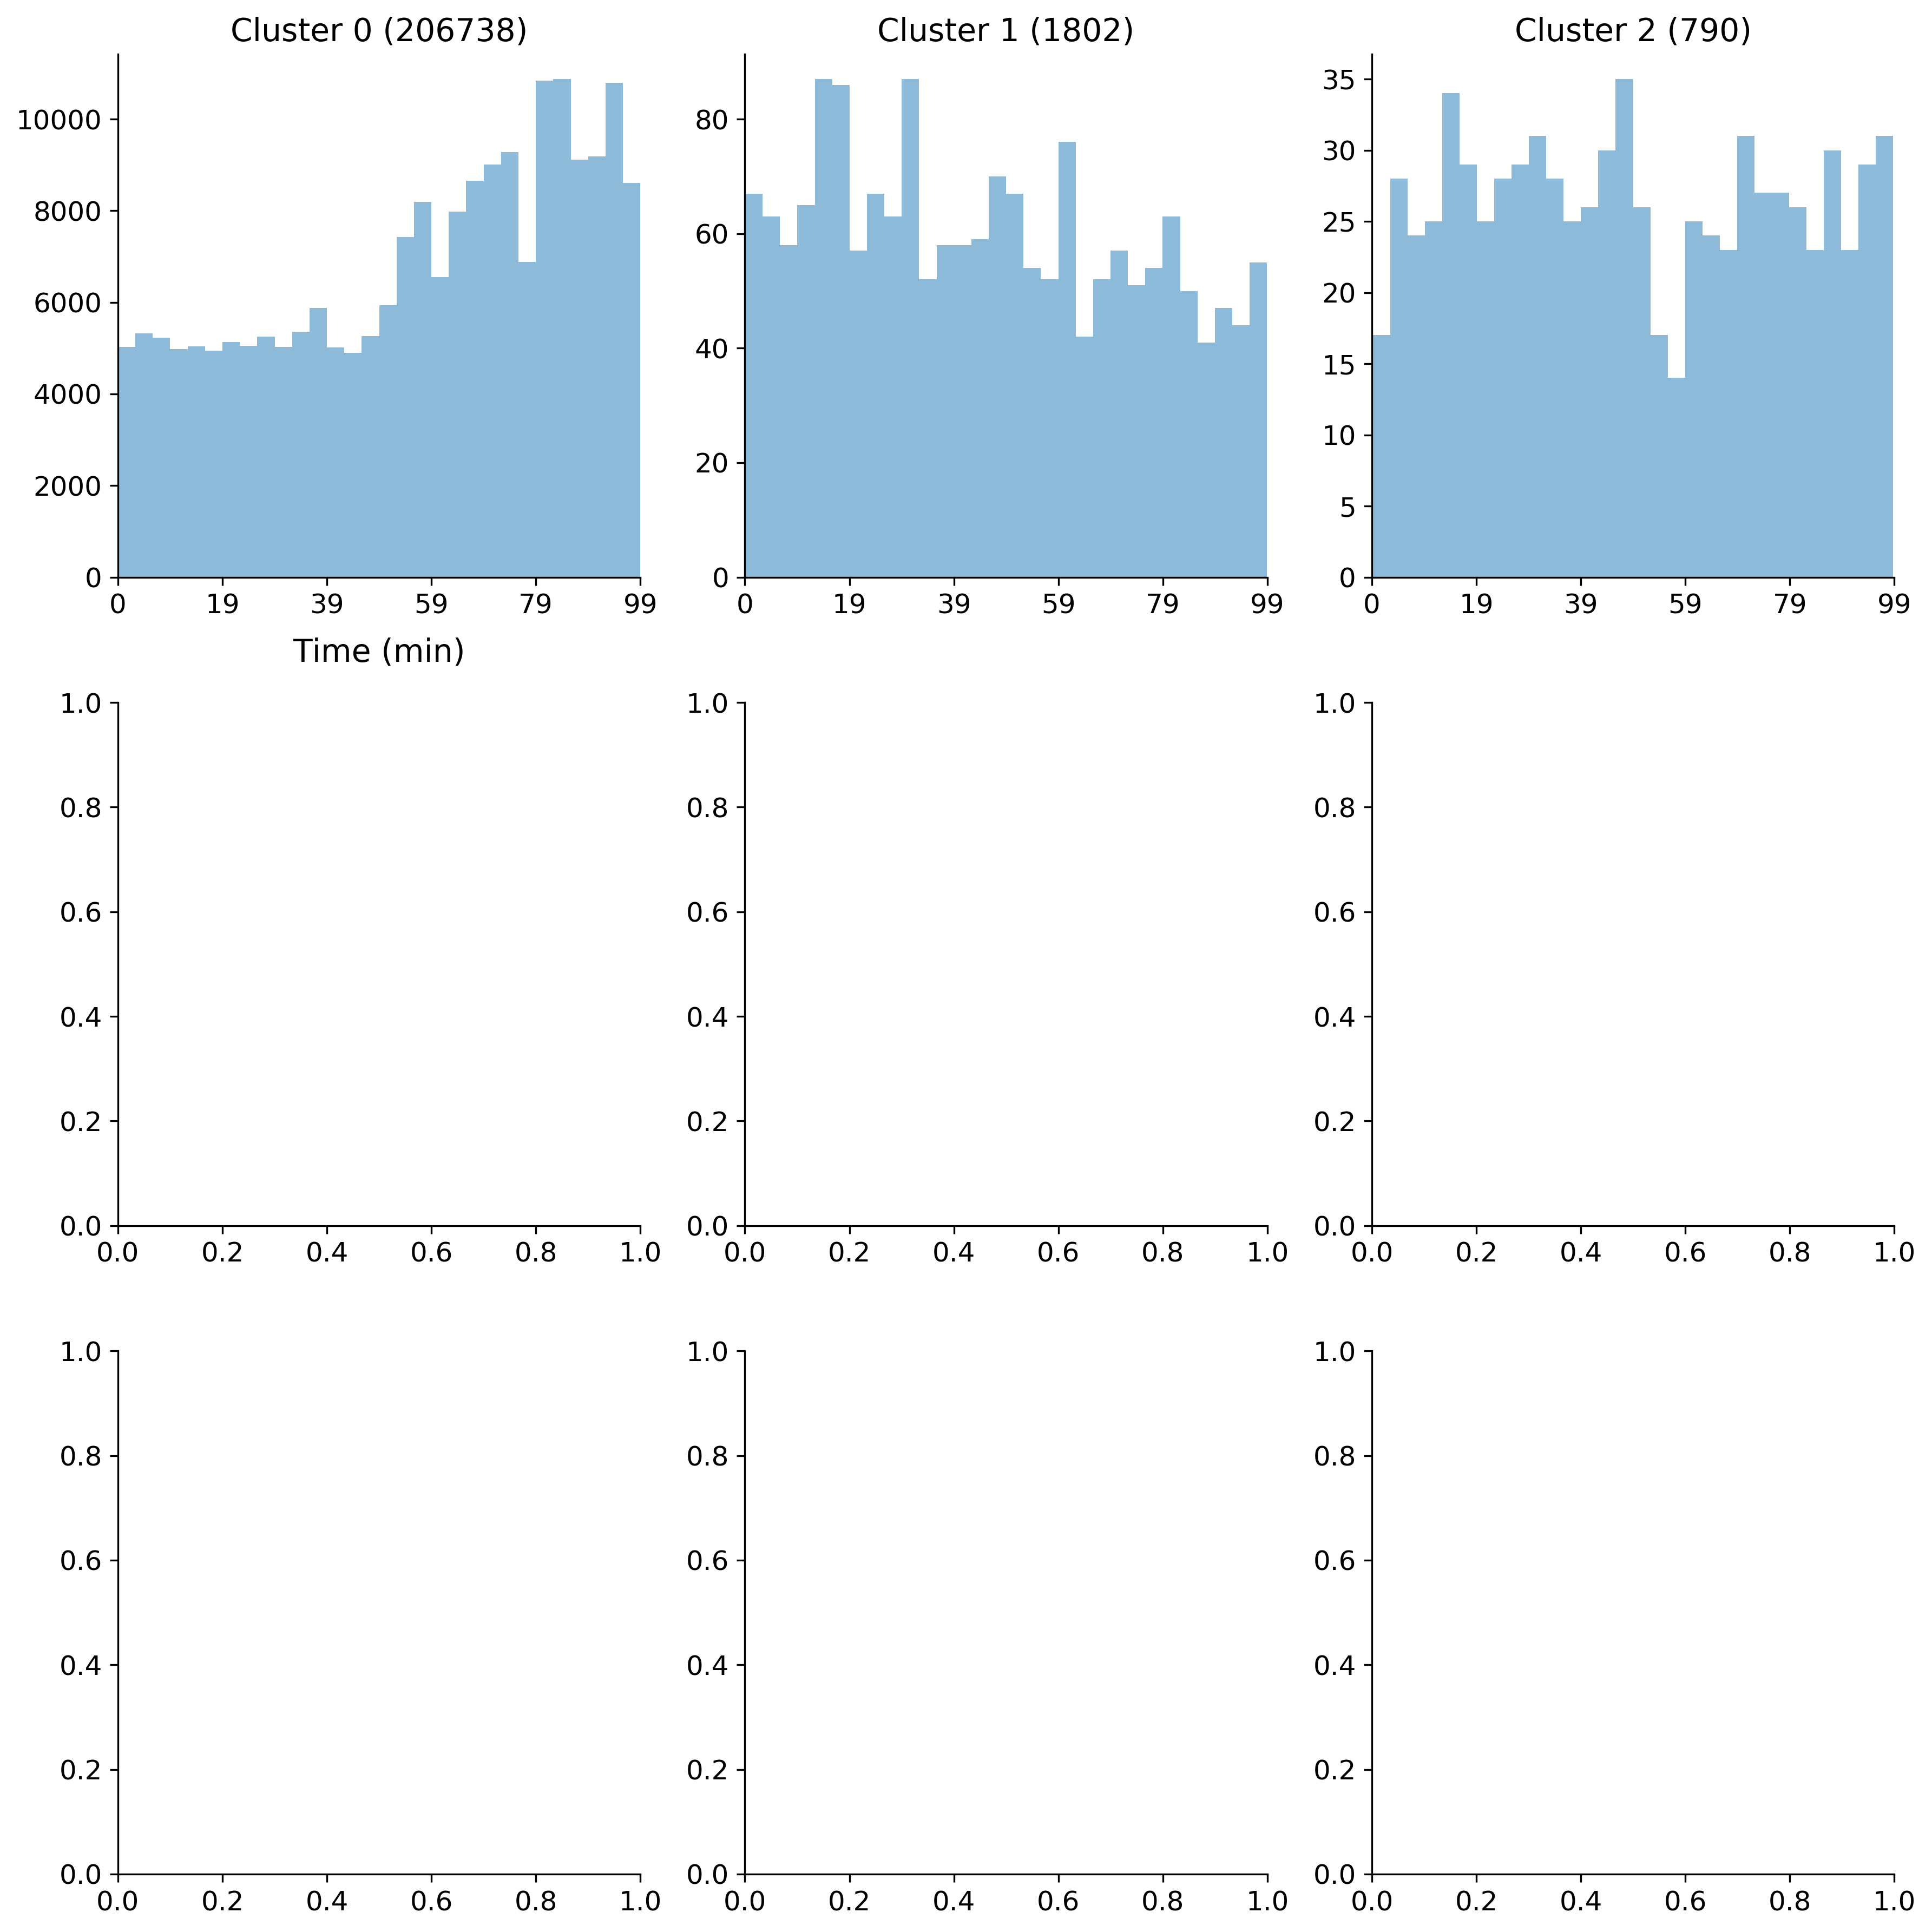

In [52]:
chan = 71
# -----------------------

wave_clusf = os.path.join(spikes_dir, 'times_CSC{}.mat'.format(chan))
if os.path.exists(wave_clusf):
    dat = loadmat(wave_clusf)['cluster_class']
    units, nspikes = np.unique(dat[:,0], return_counts=True)
    for i in range(len(units)):
        print('Unit {:.0f}: {} spikes'.format(units[i], nspikes[i]))
else:
    print('Missing {}'.format(wave_clusf))
    
fig, ax = plt.subplots(3, 3, figsize=(12, 12), dpi=300)
ax = np.ravel(ax)

tickfontsize=12
labelfontsize=14

xmin, xmax = np.min(dat[:, 1]), np.max(dat[:, 1])
i = 0
for unit in units:
#     if unit == 0:
#         continue
    dat_ = dat[np.where(dat==unit)[0], :]
    ax[i].hist(dat_[:, 1], bins=30, alpha=0.5)
    #sns.kdeplot(dat_[:, 1], linewidth=2, ax=ax[i])    
    ax[i].set_xlim(xmin, xmax)
    ax[i].set_xticks(np.linspace(xmin, xmax, 6))
    ax[i].set_xticklabels(np.linspace(xmin/6e4, xmax/6e4, 6, dtype=int), fontsize=tickfontsize)
    ax[i].set_title('Cluster {:.0f} ({})'.format(unit, len(dat_)), fontsize=labelfontsize)
    if i == 0:
        ax[i].set_xlabel('Time (min)', fontsize=labelfontsize)
    else:
        ax[i].set_xlabel('')
    i += 1
    
fig.tight_layout()

## LFP traces

In [5]:
subj_sess = 'U526_ses0'
chans = ['257', '264']
sr = 30000

subj, sess = subj_sess.split('_')

In [6]:
is_blackrock = True
lfp_dir = '/Users/danielschonhaut/Box Sync/penn/rotations/kahana/projects/time_cells/data/{}/{}/micro_lfps'.format(subj, sess)
save_data = False
save_fname = os.path.join(lfp_dir, 'CSC{}.pkl')

# ----------------------------
# Load LFPs.
lfps = []
for chan in chans:
    f = os.path.join(lfp_dir, 'CSC{}.mat'.format(chan))
    if not os.path.exists(f):
        print('Missing {}'.format(f))
        continue
    with h5py.File(f, 'r') as f:
        lfp = np.squeeze(f['data'])
    # Divide Blackrock LFPs by 4 to put values in microvolts.
    if is_blackrock:
        lfp = lfp / 4.0
    savef = save_fname.format(chan)
    if (save_data) and (not os.path.exists(savef)):
        dio.save_pickle(lfp, savef)
    lfps.append(lfp)
lfps = np.array(lfps)
print('LFPs: {}'.format(lfps.shape))
del lfp

# Load LFP timestamps.
lfp_timestamps_f = os.path.join(lfp_dir, 'lfpTimeStamps_micro.mat')
if os.path.exists(lfp_timestamps_f):
    with h5py.File(os.path.join(lfp_dir, 'lfpTimeStamps_micro.mat'), 'r') as f:
        lfp_timestamps = np.squeeze(f['timeStamps'])
        print('lfpTimeStamps_micro.mat: {}'.format(lfp_timestamps.shape))
else:
    print('Missing lfpTimeStamps_micro.mat')

LFPs: (2, 123585946)
Missing lfpTimeStamps_micro.mat


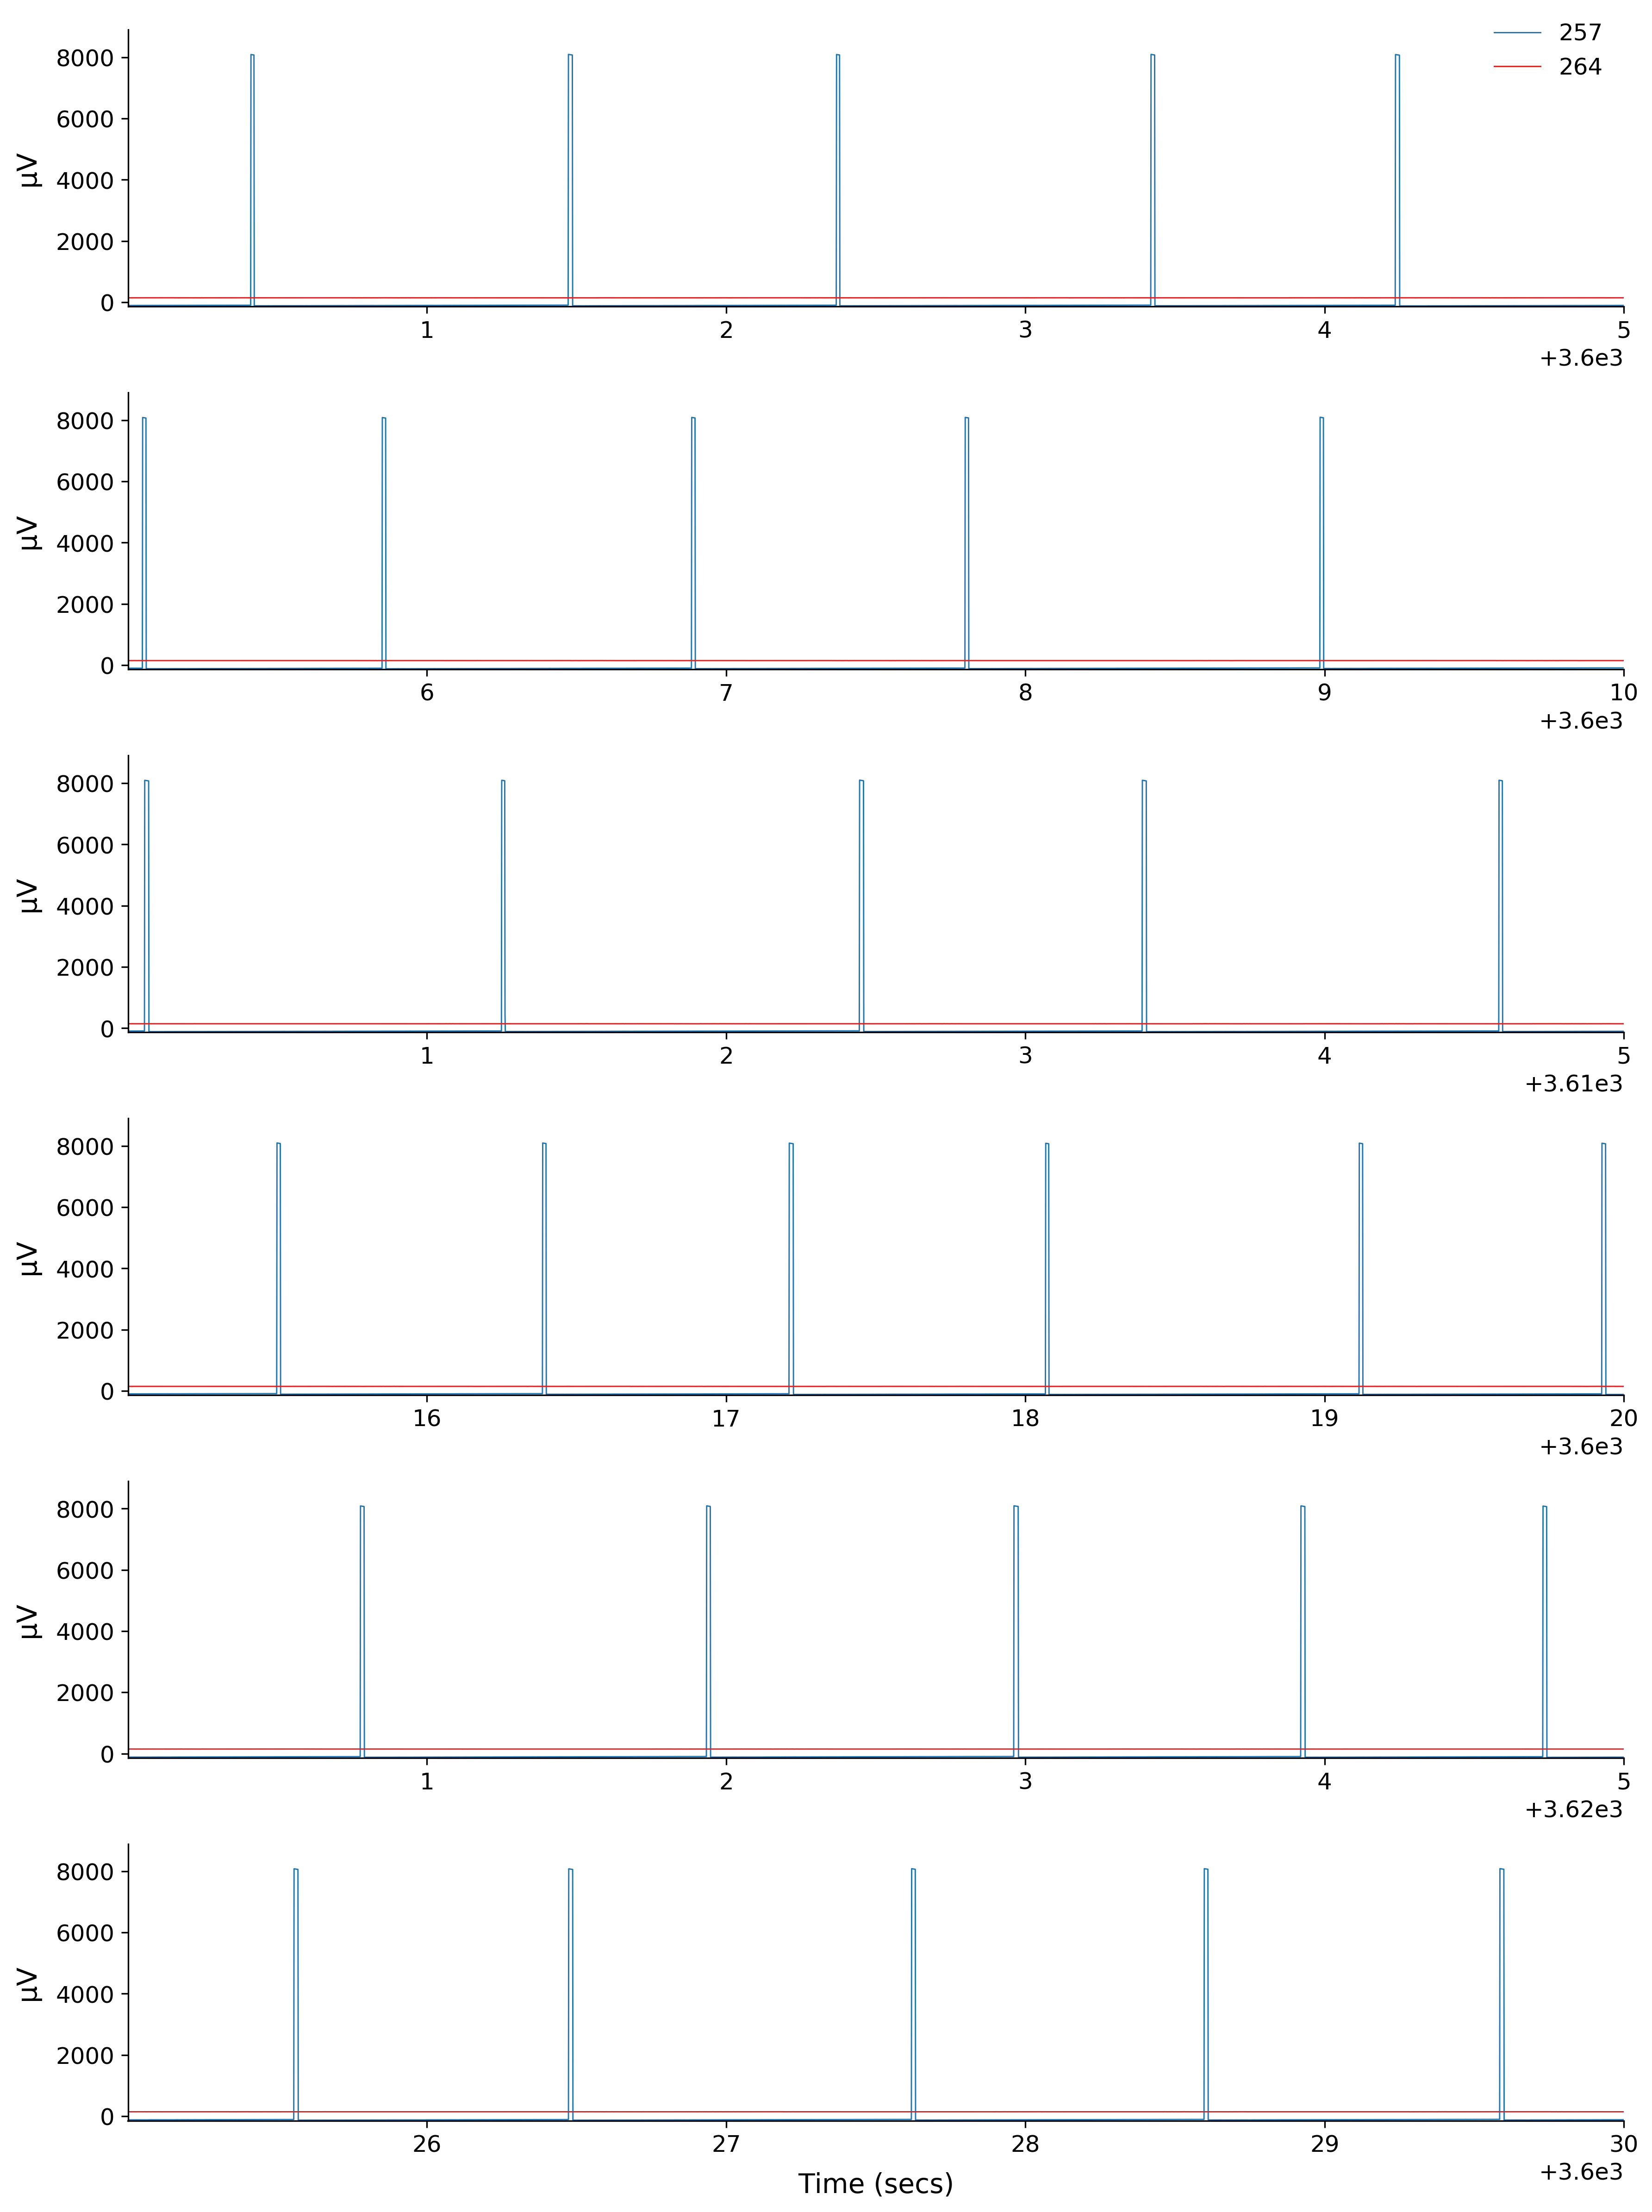

In [10]:
iChans = [0, 1]

labelfontsize = 14
tickfontsize = 12
fig, ax = plot_trace2(lfps[iChans,::30]*1e-6, 
                      start=60*60, 
                      duration=30, 
                      x_units='secs', 
                      colors=colors,
                      sampling_rate=1000,#sr,
                      legend_size=tickfontsize,
                      legend_labels=['257', '264'],
                      tickfontsize=tickfontsize,
                      labelfontsize=labelfontsize,
                      same_yaxis=False)
# ax[0].set_ylim([-200, 200])
# ax[0].set_xlabel('Time (ms)', fontsize=labelfontsize, labelpad=8)
# ax[0].set_ylabel('$\mu$V', fontsize=labelfontsize, labelpad=8)

In [65]:
# Downsample and notch filter LFPs.
#rsr = 2000
rsr = 0

lfps = eeg_preproc.process_lfp(lfps, subj_sess, chans, 
                               sampling_rate=sr, 
                               resampling_rate=rsr, 
                               notch_freqs=[60, 120, 180],
                               mean_sub=True)

In [97]:
# dat = dio.open_pickle(os.path.join(lfp_dir, 'CSC25.pkl'))
# dat_ = mne.filter.filter_data(dat, sfreq=sr, l_freq=300, h_freq=1000, verbose=False)

Setting up band-pass filter from 3e+02 - 1e+03 Hz
l_trans_bandwidth chosen to be 75.0 Hz
h_trans_bandwidth chosen to be 250.0 Hz
Filter length of 1321 samples (0.044 sec) selected


In [23]:
# fname = os.path.join(lfp_dir, 'processed', 'test.mat')
# savemat(fname, {'chan': np.arange(20)})
# loadmat(fname)

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Jan  5 15:28:19 2020',
 '__version__': '1.0',
 '__globals__': [],
 'chan': array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19]])}

In [76]:
# # Save processed LFP channels.
# fext = '.mat' # .pkl or .mat

# # ----------------------------
# fname = os.path.join(lfp_dir, 'processed', 'CSC{}-muV-{}Hz-notchfilt' + fext)

# if fext == '.pkl':
#     for chan in chans:
#         dio.save_pickle(lfps.sel(channel=chan).data, fname.format(chan, int(lfps.samplerate)))
# elif fext == '.mat':
#     for chan in chans:
#         savemat(fname.format(chan, int(lfps.samplerate)), {'chan': lfps.sel(channel=chan).data})
# else:
#     print('File type not supported.')

In [57]:
import eeg_plotting
reload(eeg_plotting)
from eeg_plotting import plot_trace, plot_trace2

In [68]:
lfps.data.shape#[iChans,::30].shape

(5, 179877325)

In [75]:
# iChans = [1, 4]

# labelfontsize = 14
# tickfontsize = 12
# fig, ax = plot_trace2(lfps.data[iChans,::30]*1e-6, 
#                       start=30*60, 
#                       duration=30, 
#                       x_units='secs', 
#                       colors=colors,
#                       sampling_rate=1000,#sr,
#                       legend_size=tickfontsize,
#                       legend_labels=['ch2', 'ch25'],
#                       tickfontsize=tickfontsize,
#                       labelfontsize=labelfontsize,
#                       same_yaxis=False)
# # ax[0].set_ylim([-200, 200])
# # ax[0].set_xlabel('Time (ms)', fontsize=labelfontsize, labelpad=8)
# # ax[0].set_ylabel('$\mu$V', fontsize=labelfontsize, labelpad=8)

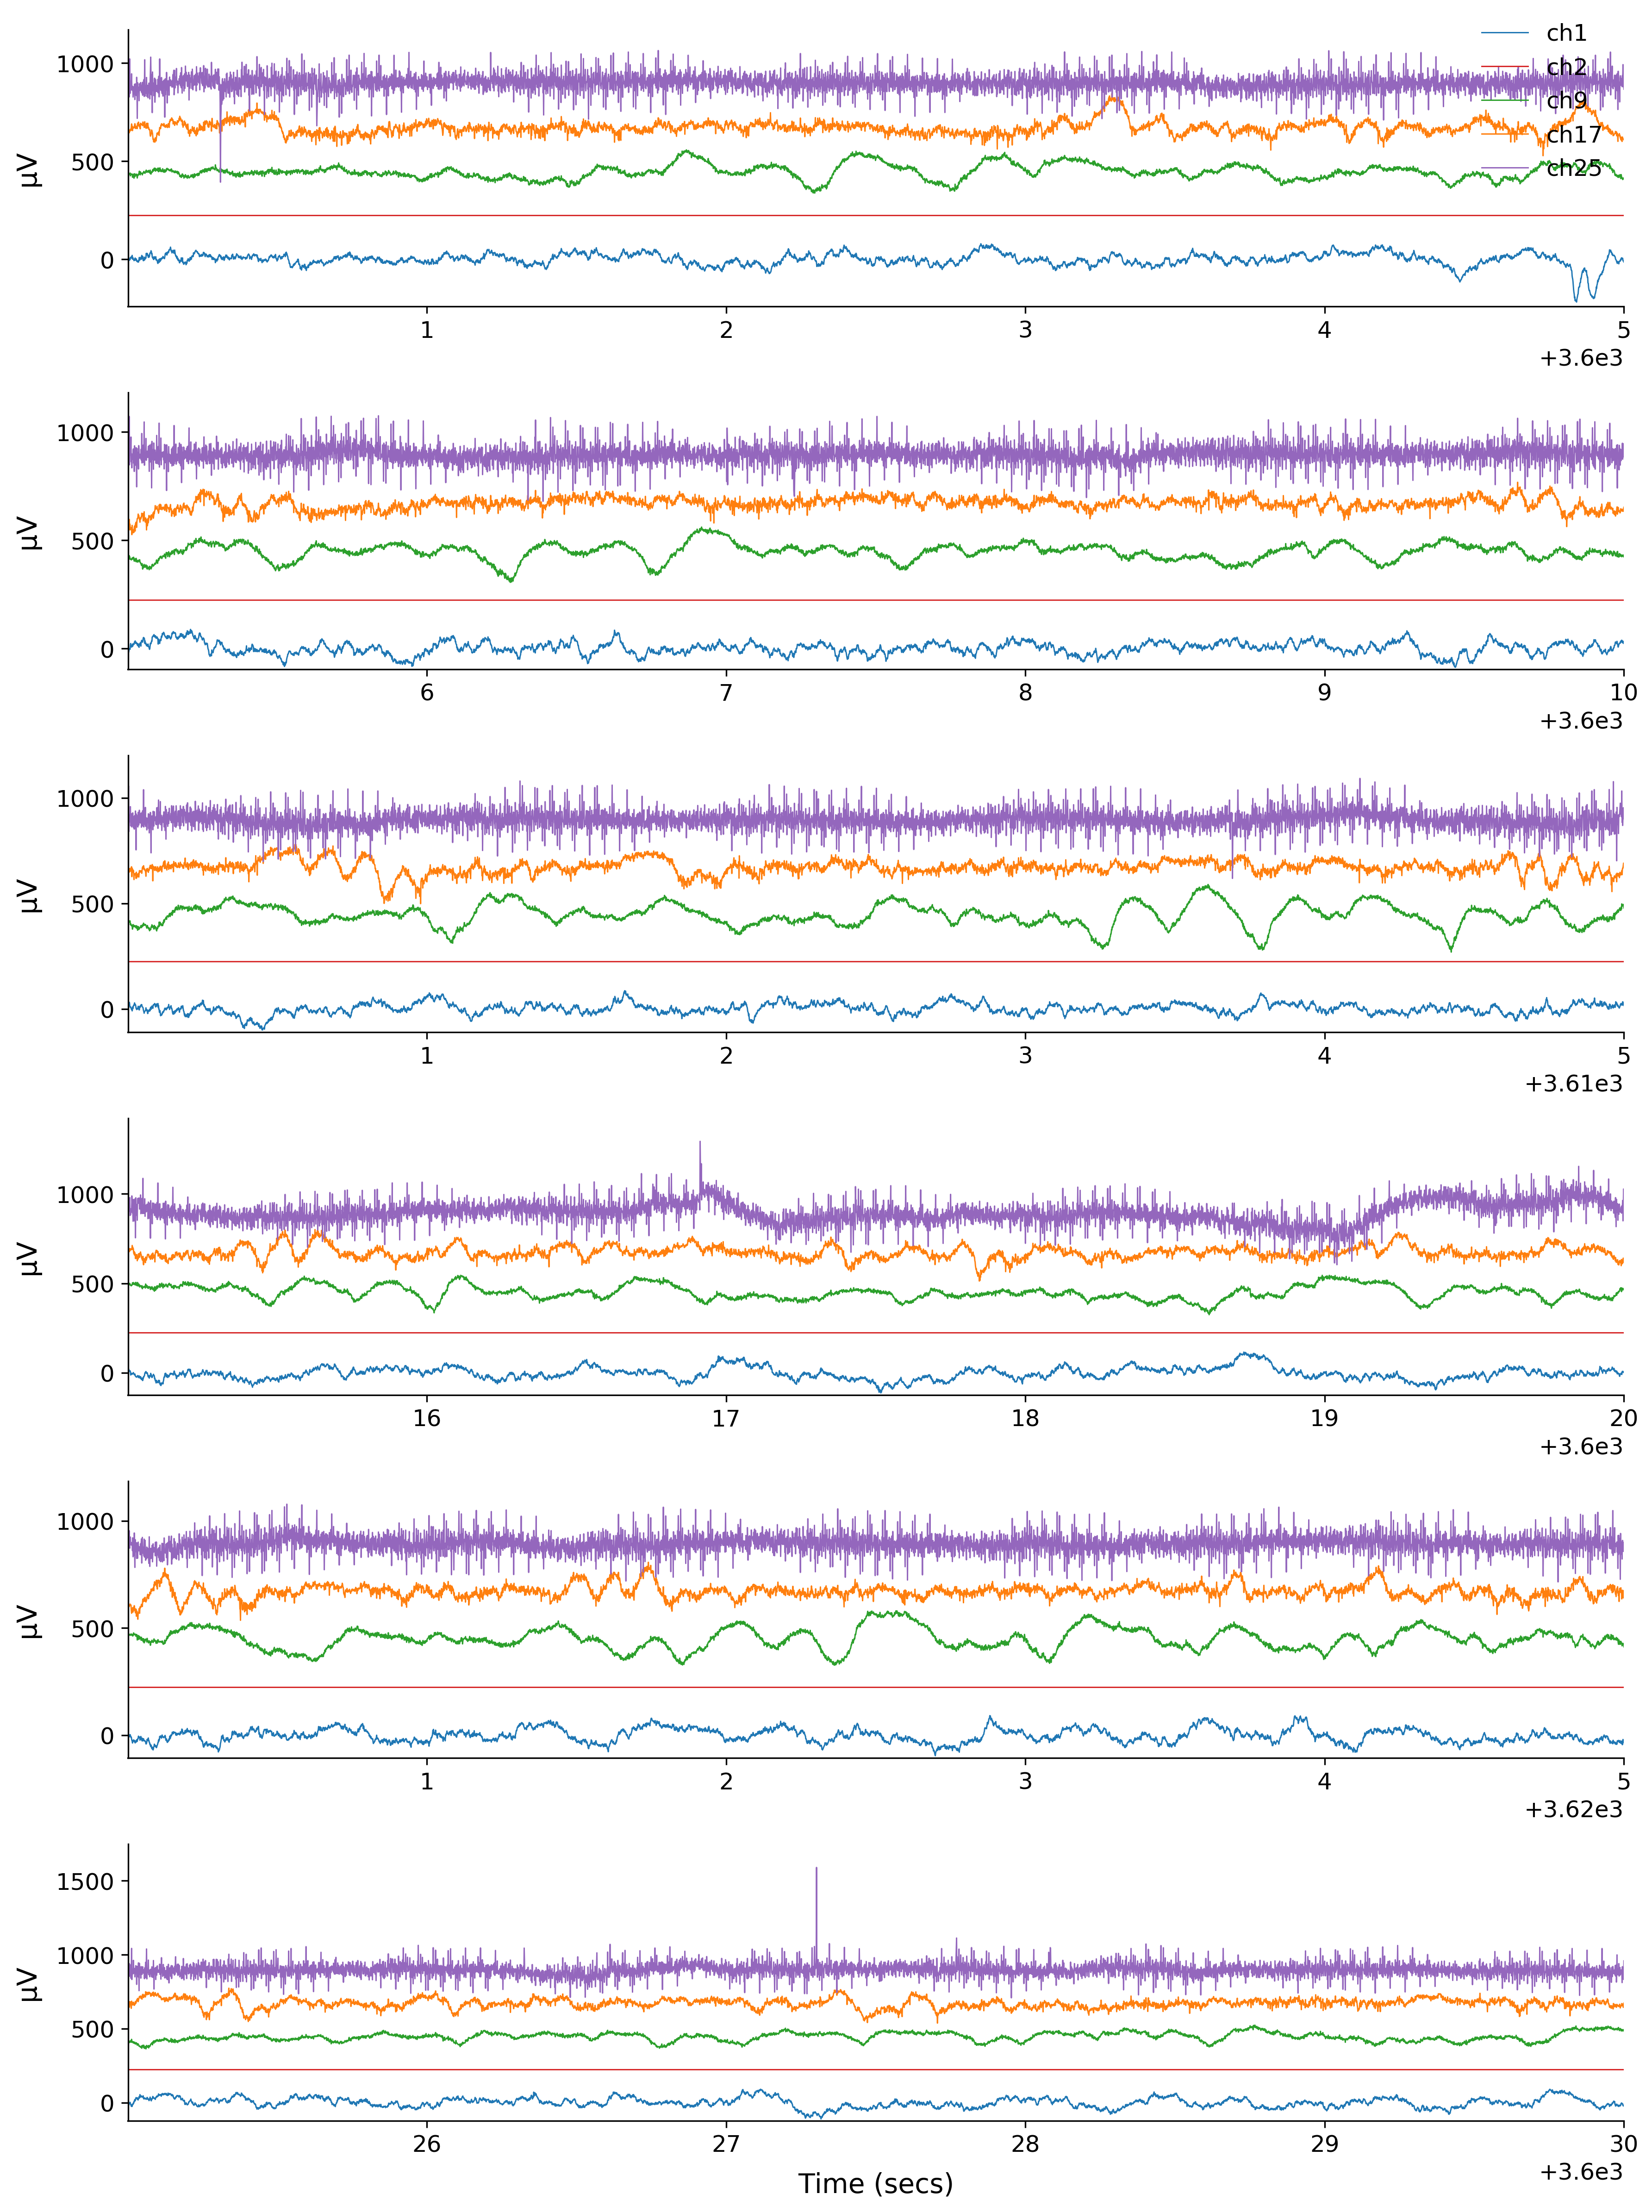

In [76]:
iChans = [0, 1, 2, 3, 4]

labelfontsize = 14
tickfontsize = 12
fig, ax = plot_trace2(lfps.data[iChans,::30]*1e-6, 
                      start=60*60, 
                      duration=30, 
                      x_units='secs', 
                      colors=colors,
                      sampling_rate=1000,#sr,
                      legend_size=tickfontsize,
                      legend_labels=['ch1', 'ch2', 'ch9', 'ch17', 'ch25'],
                      tickfontsize=tickfontsize,
                      labelfontsize=labelfontsize,
                      same_yaxis=False)
# ax[0].set_ylim([-200, 200])
# ax[0].set_xlabel('Time (ms)', fontsize=labelfontsize, labelpad=8)
# ax[0].set_ylabel('$\mu$V', fontsize=labelfontsize, labelpad=8)

Text(0.5,489.5,'Time (ms)')

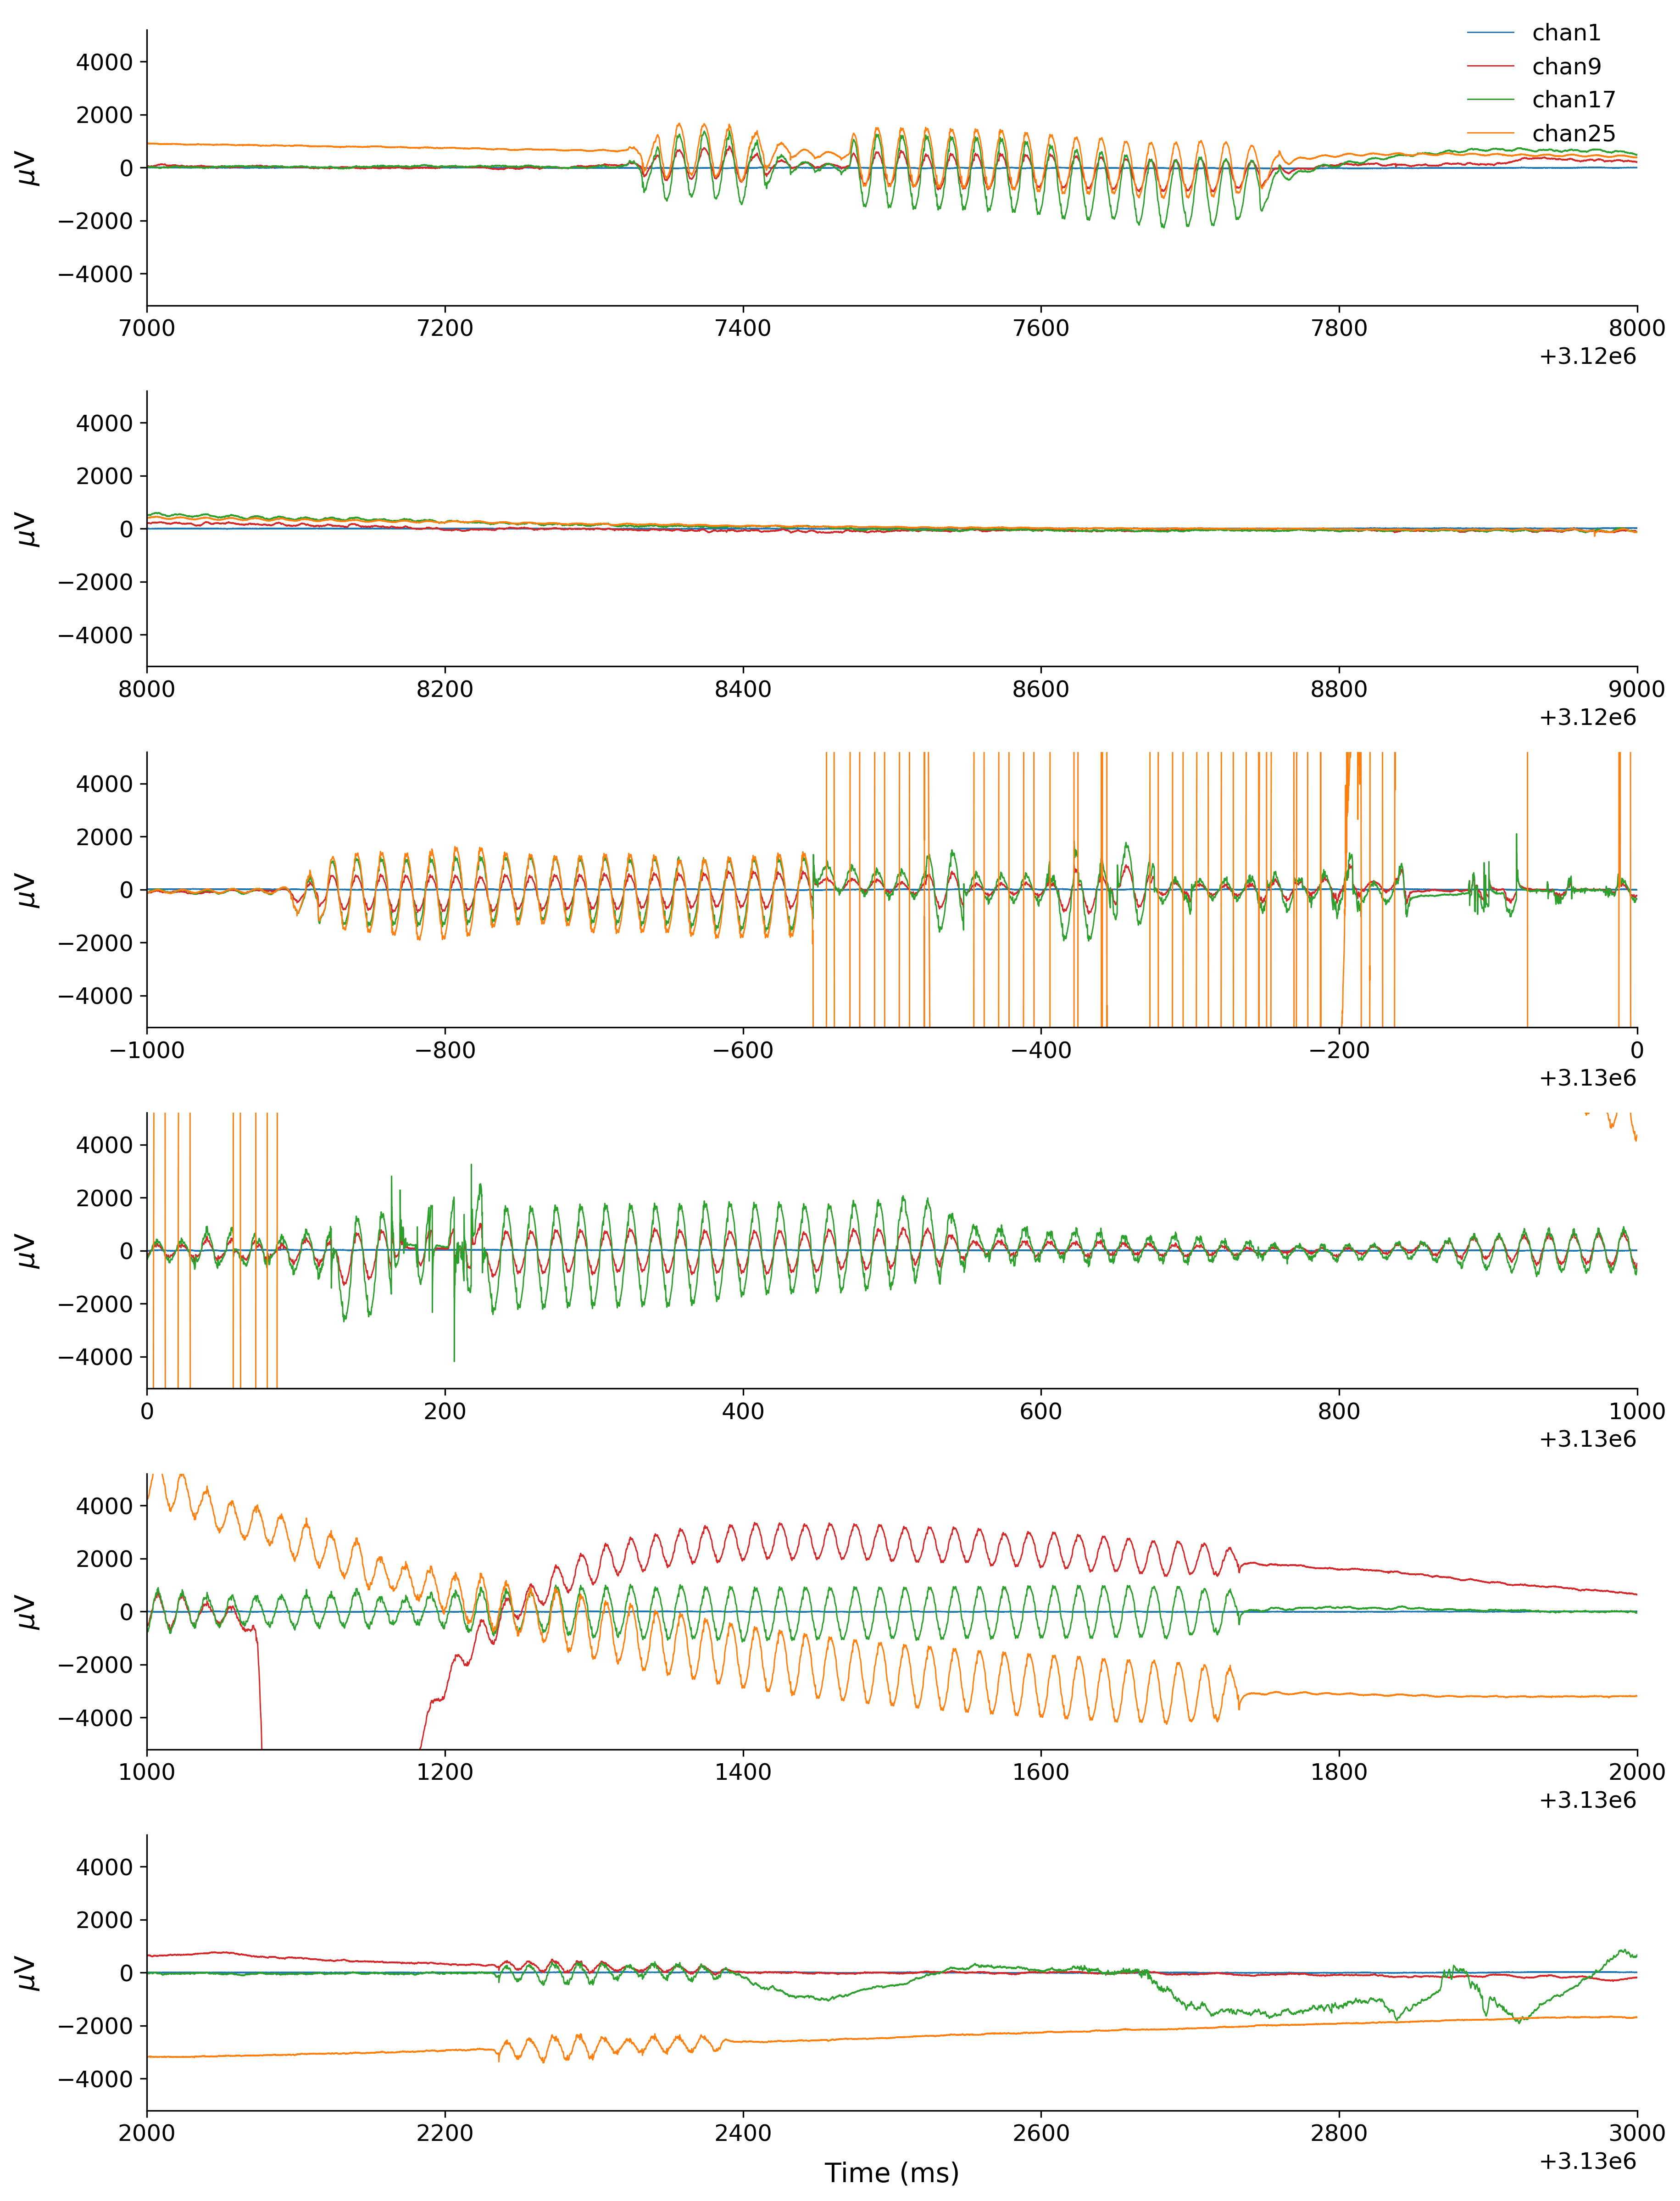

In [27]:
iChan = [0, 1, 2, 3, 4]

labelfontsize = 14
tickfontsize = 12
fig, ax = plot_trace2(lfps[iChan,:], 
                      start=52*6e4 + 7e3, duration=6e3, x_units='ms', 
                      sampling_rate=sr,
                      legend_size=tickfontsize,
                      legend_labels=['chan1', 'chan9', 'chan17', 'chan25'])
for i in range(len(ax)):
    ax[i].set_ylim([-5200, 5200])
    ax[i].set_ylabel('$\mu$V', fontsize=labelfontsize, labelpad=8)
ax[-1].set_xlabel('Time (ms)', fontsize=labelfontsize, labelpad=8)

In [13]:
print('Session is {:.1f} mins'.format(len(lfps.time) / (int(lfps.samplerate) * 60)))

Session is 62.3 mins


/Users/danielschonhaut/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


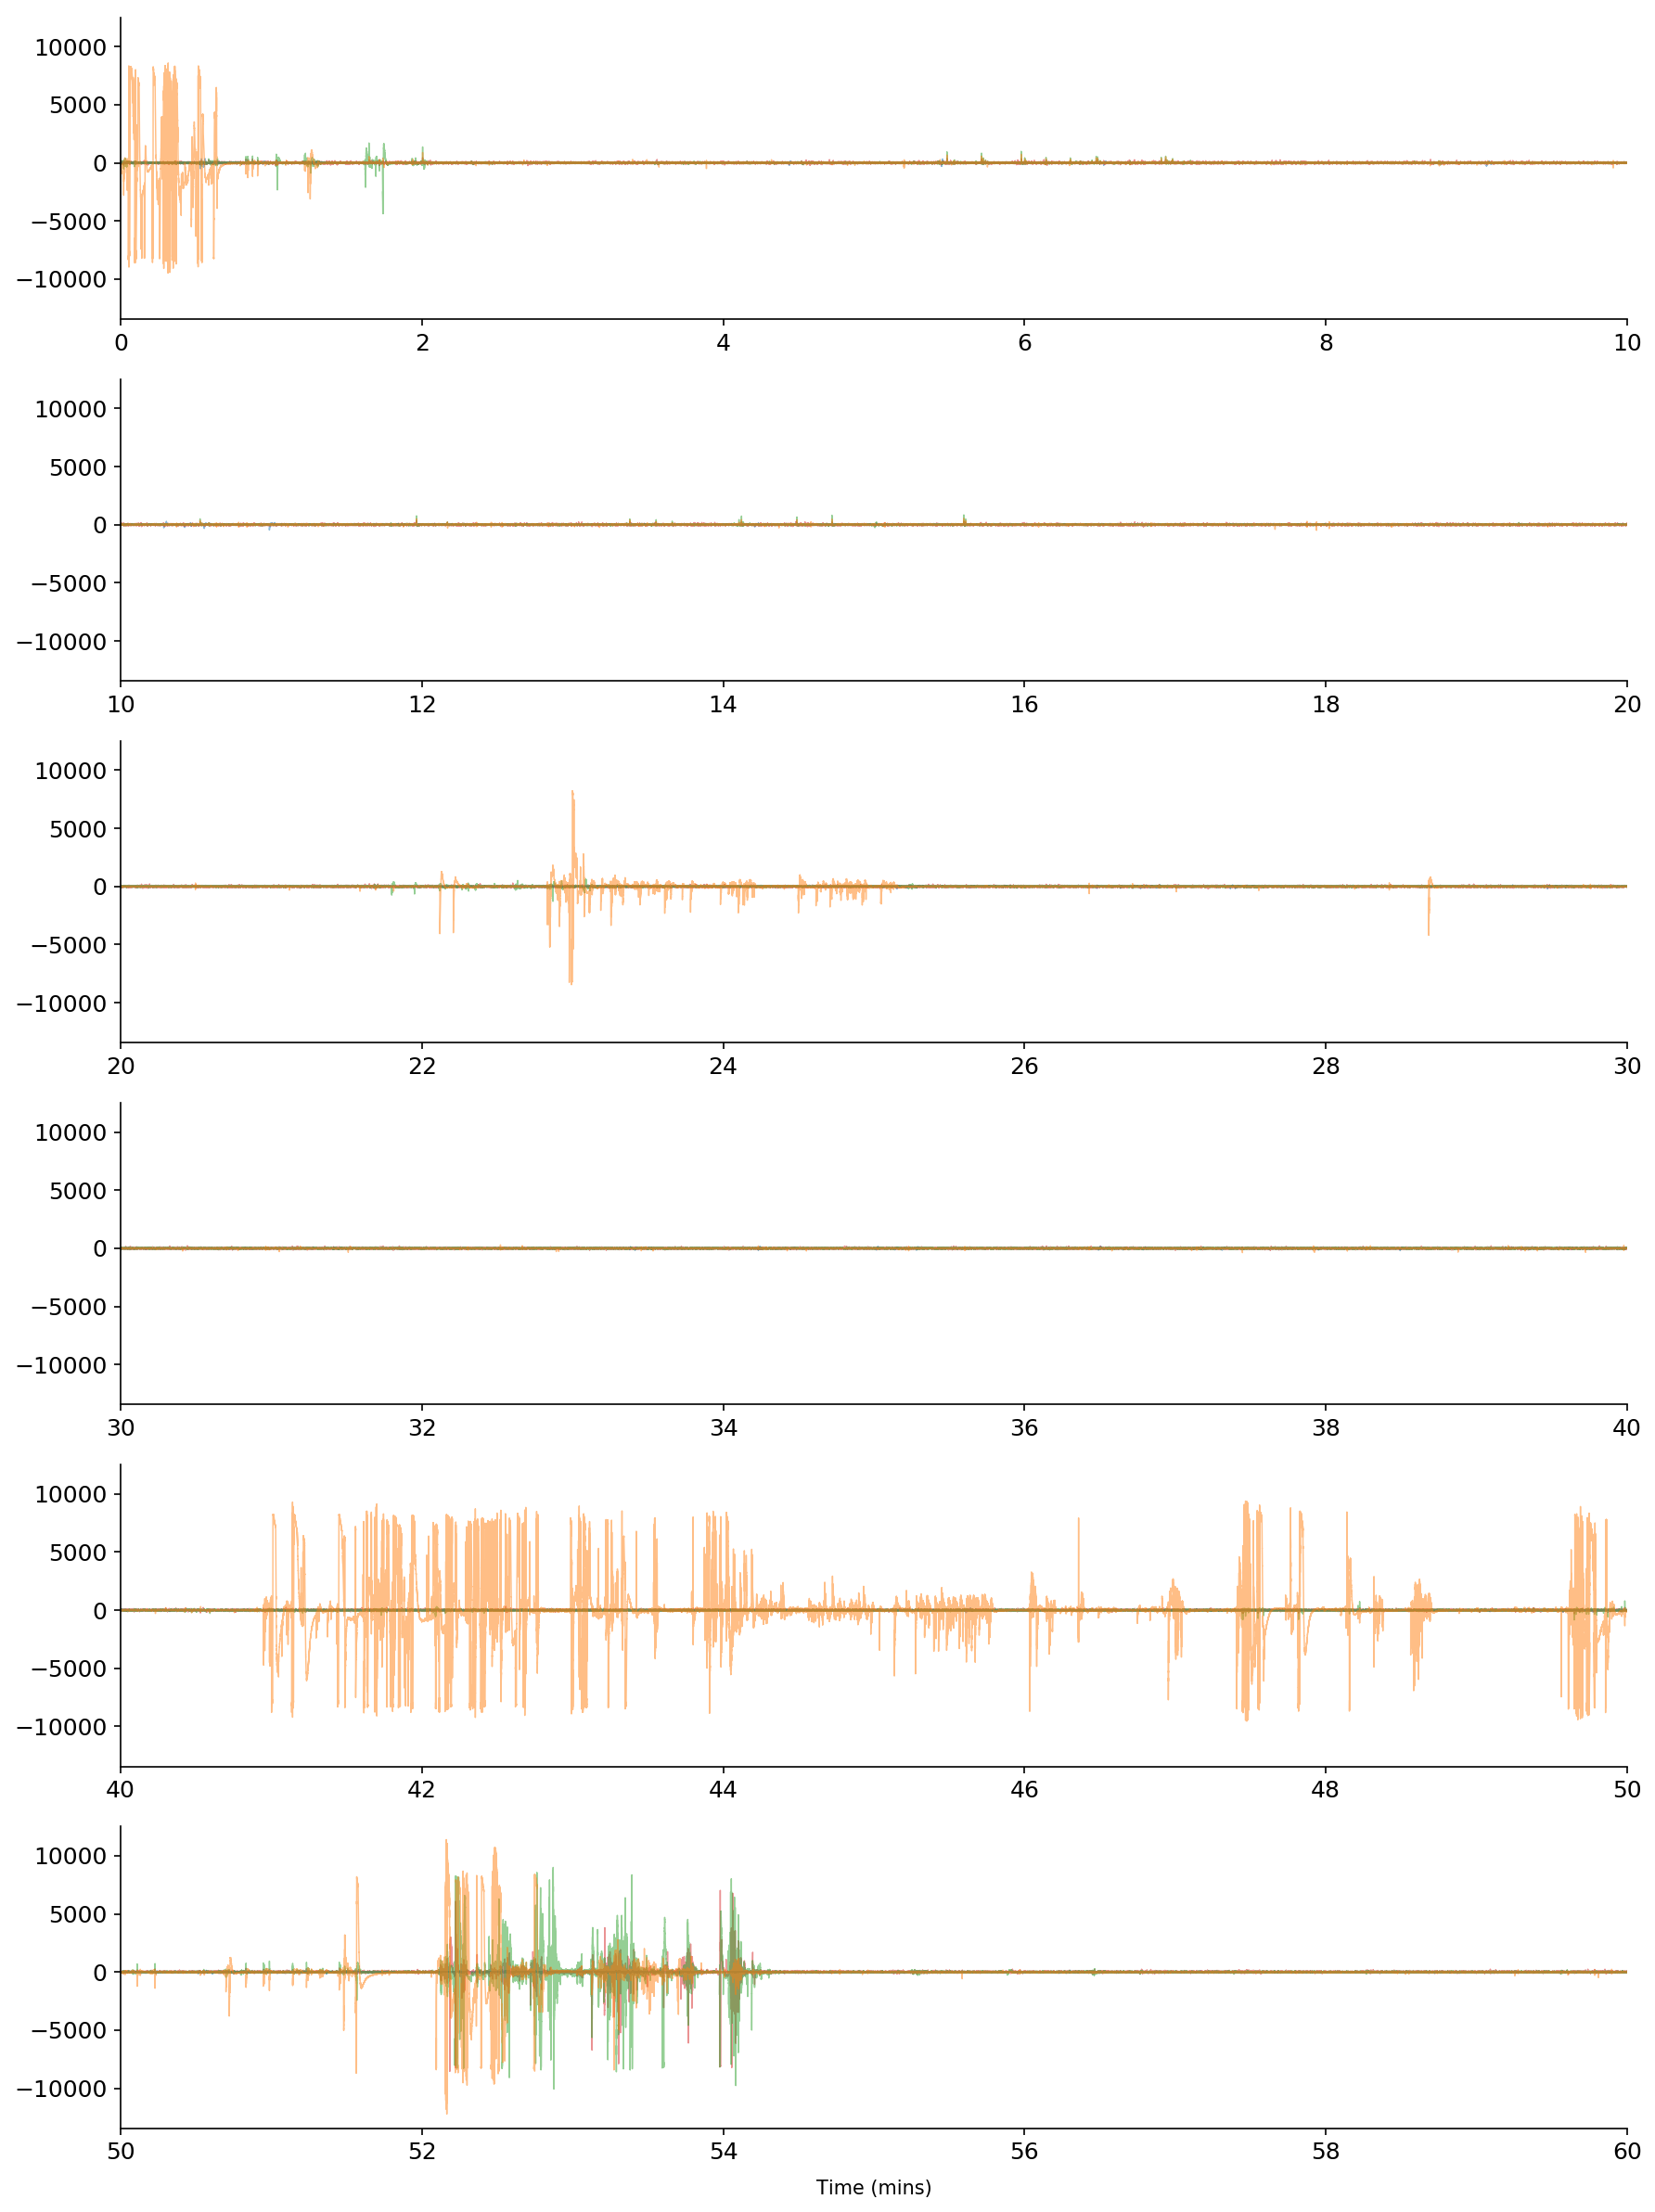

In [25]:
fig, ax = plot_trace2(lfps, start=0, duration=60, x_units='mins', sampling_rate=2000, 
                      alphas=[0.5]*len(lfps), dpi=150)

fig.show()